In [111]:
from __future__ import print_function
import pickle
import numpy as np
import pandas as pd
import matplotlib as mpl
try:
    import matplotlib.pyplot as plt
except:
    mpl.use("Agg")
    import matplotlib.pyplot as plt
    
import fitsio as fio    
import ngmix.medsreaders
import galsim
import galsim.des
import images

# Prepare DATA

## MEDS file paths

In [2]:
meds_g_path = "/e/eser2/vargatn/DES/Y3_DATA/DEEP3/SN-C3_C01_r3688p01/SN-C3_C01_r3688p01_g_meds-Y3A2_DEEP.fits.fz"
meds_r_path = "/e/eser2/vargatn/DES/Y3_DATA/DEEP3/SN-C3_C01_r3688p01/SN-C3_C01_r3688p01_r_meds-Y3A2_DEEP.fits.fz"
meds_i_path = "/e/eser2/vargatn/DES/Y3_DATA/DEEP3/SN-C3_C01_r3688p01/SN-C3_C01_r3688p01_i_meds-Y3A2_DEEP.fits.fz"

In [58]:
meds_paths = [
    meds_g_path,
    meds_r_path,
    meds_i_path,
]
mms = [ngmix.medsreaders.NGMixMEDS(path) for path in meds_paths]

## PSFex files path

In [4]:
psfex_g_path = "/e/eser2/vargatn/DES/Y3_DATA/DEEP3/SN-C3_C01_r3688p01/SN-C3_C01_r3688p01_g_psfcat.psf"
psfex_r_path = "/e/eser2/vargatn/DES/Y3_DATA/DEEP3/SN-C3_C01_r3688p01/SN-C3_C01_r3688p01_r_psfcat.psf"
psfex_i_path = "/e/eser2/vargatn/DES/Y3_DATA/DEEP3/SN-C3_C01_r3688p01/SN-C3_C01_r3688p01_i_psfcat.psf"

In [6]:
psfex_paths = [
    psfex_g_path,
    psfex_r_path,
    psfex_i_path,
]

## MOF path

In [28]:
fname = "/e/eser2/vargatn/DES/Y3_DATA/DEEP3/run-d02-SN-C3_C01_r3688p01.fits"
allmofs = fio.read(fname).byteswap().newbyteorder()

# Renderer class

In [112]:
class ComparePostage():
    _icutout = 0
    _bands = ("g", "r", "i", "z")
    def __init__(self, moftab, mms, psfex_files=None):
        """
        Currently this works strictly in BDF mode of MOF results
        
        Parameters:
        -----------
        moftab: record_array
            MOF rows to render
        mms: list
            list of ngmix.medsreaders.NGMixMEDS objects, one for each band
        psfex_files: list
            list of psfex file paths corresponding to each MEDS files
            
        """
        self.mof = moftab
        self.mms = mms
        self.psfex_files = psfex_files
        
        self.medsrow = self._get_indexarray()
        
    def _get_indexarray(self):
        imof = pd.DataFrame()
        imof["mofid"] = mof["id"].byteswap().newbyteorder()
        
        imeds = pd.DataFrame()
        imeds["medsid"] = m["id"].byteswap().newbyteorder()
        imeds["medsrow"] = np.arange(len(m["id"])) 
        
        tmp = pd.merge(imof, imeds, how="inner", left_on="mofid", right_on="medsid")
        return tmp["medsrow"].values       
        
    def get_cutouts(self, iobj, iband):
        """
        iobj should refer to the id in the mof file,
        and we should look up here which meds line it corresponds to. this is stored in self.medsrow
        """
        m = self.mms[iband]
 
        imeds = self.medsrow[iobj]
        print(imeds)
        obs_im = m.get_cutout(imeds, self._icutout)

        jac = m.get_jacobian(imeds, self._icutout)
        wcs = galsim.JacobianWCS(jac["dudcol"], jac["dudrow"], jac["dvdcol"], jac["dvdrow"])

        obs_ii = galsim.Image(obs_im, wcs=wcs)  

        orig_x = m["orig_col"][imeds, 0]
        orig_y = m["orig_row"][imeds, 0]    
        orig_pos = galsim.PositionD(orig_x, orig_y)
        des_psf = galsim.des.DES_PSFEx(self.psfex_files[iband], wcs=wcs)
        psf = des_psf.getPSF(orig_pos)    

#         fracdev = self.mof["fracdev"].iloc[iobj]

        flux = self.mof["bdf_flux"][iobj, iband]

        band_pars = np.zeros(7)
#         for i in np.arange(6):
        band_pars[:6] = self.mof["bdf_pars"][iobj, :6]
#             band_pars[i] = self.mof["bdf_pars_"+str(i)].iloc[iobj]
        band_pars[6] = flux
        galmaker = ngmix.gmix.GMixModel(band_pars, 'bdf')
        gal = galmaker.make_galsim_object()

        gal = galsim.Convolve(gal, psf)

        gal_ii = gal.drawImage(nx=obs_ii.array.shape[0], ny=obs_ii.array.shape[1],
                               wcs=wcs)   
        return obs_ii, gal_ii        
        
    def draw_postage(self):

        for iobj in np.arange(len(self.mof)):
            g_obs, g_gal = self.get_cutouts(iobj, 0)
            r_obs, r_gal = self.get_cutouts(iobj, 1)
            i_obs, i_gal = self.get_cutouts(iobj, 2)

            mv = np.min((g_obs.array, r_obs.array, i_obs.array))
            mos_g = np.hstack([g_obs.array - mv, g_gal.array- mv, g_obs.array - g_gal.array - mv])
            mos_r = np.hstack([r_obs.array - mv, r_gal.array- mv, r_obs.array - r_gal.array - mv])
            mos_i = np.hstack([i_obs.array - mv, i_gal.array- mv, i_obs.array - i_gal.array - mv])

            factor = 0.02
            scales = np.array([1., 1., 1.3]) * factor
            nonlinear = 0.5
            clip = None        

            obs_im = images.get_color_image(mos_i, mos_r, mos_g,
                                            nonlinear=nonlinear, clip=clip, scales=scales)    

            fig, axarr = plt.subplots(ncols=1, nrows=2, figsize=(12, 6))
            fig.subplots_adjust(hspace=0.05)

            axarr[0].set_xticks([])
            axarr[0].set_yticks([])

            axarr[0].imshow(obs_im / obs_im.max())

            axarr[1].set_xticks([])
            axarr[1].set_yticks([])

            mos = mos_g + mos_r + mos_i

            mos_im = mos
            cim = axarr[1].imshow(mos_im)
            position=fig.add_axes([0.8,0.125,0.01,0.37])

            cb = fig.colorbar(cim, position)
            cb.set_label("g + r + i flux")

            fig.text(0.25, 0.9, "ID: {:d}".format(mof["id"][iobj]),
                     fontsize=16)

#             fig.savefig("stamps-6/test_"+str(iobj)+".pdf", dpi=300, bbox_inches="tight")    
#             fig.savefig("stamps-6/test_"+str(iobj)+".png", dpi=300, bbox_inches="tight")            
#             return fig, axarr

# Postage rendered

In [113]:
mof = alllmofs[[10353, 7424, 9237]]
mof = alllmofs[[10353,]]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4073
4073
4073


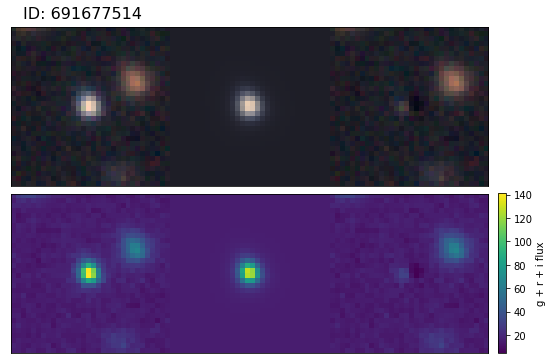

In [117]:
cpost = ComparePostage(mof, mms, psfex_paths)
cpost.draw_postage()